## 1. Using Data Augmentation to increase dataset size

Data augmentation is a technique to increase the number of samples within the dataset by applying some transformations on the images (rotation, flipping, shearing,...etc).
<br>The code will change slightly using this technique, mainly for the model.fit function will change to model.fit_generator

Loading Training Samples...
0- [dogs] with total of 4005 samples
1- [cats] with total of 4000 samples
Loading Test Samples...
0- [dogs] with total of 1012 samples
1- [cats] with total of 1011 samples


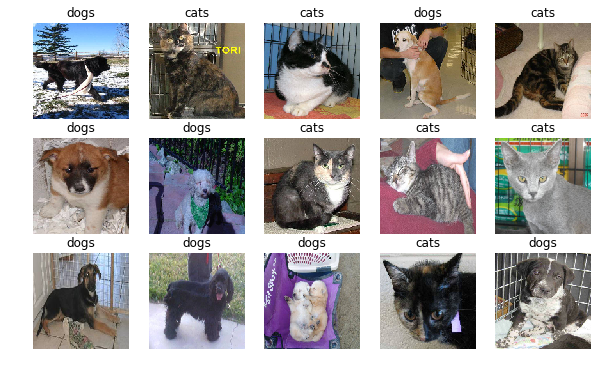

In [25]:
import numpy as np
import PML
import matplotlib.pyplot as plt
%matplotlib inline

TARGET_WIDTH=150
TARGET_HEIGHT=150

print("Loading Training Samples...")
samples,labels=PML.load_img_dataset_from_folder("datasets/catsdogs",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=False)
#load test samples
print("Loading Test Samples...")
sample_test,labels_test=PML.load_img_dataset_from_folder("test/catsdogs/",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=False)

PML.plot_random_images(samples,labels=labels,rows=3,cols=5)

In [26]:

from tensorflow.keras import utils
import random
import PML

#shuffle samples order
random.shuffle(samples)

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])
 
#Prepared to convolutional samples (3 channels per sample)
X=PML.prepare_conv_samples(X)
#normalize values
x_train,normalizer=PML.normalize_image(X)

#prepare labels to one-hot-encoding
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 7204 samples
Validating using: 801 samples


Here we define the image data generator that will generate new images based on the parameters spcified.

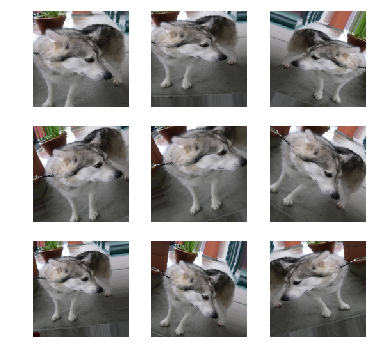

In [28]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen=ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                       height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                       horizontal_flip=True, fill_mode="nearest")

#plot some random generated images
i=1
count=3
fig=plt.figure(figsize=(count*2,count*2))
for b in gen.flow(np.array([X_train[0]]),batch_size=1):
    fig.add_subplot(count,count,i)
    plt.axis('off')
    img=plt.imshow(image.array_to_img(b[0,:,:,:]))
    i+=1
    if(i>count*count):
        break
        
plt.show()

In [ ]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

input_shape=(TARGET_WIDTH,TARGET_HEIGHT,3)
BatchSize=32

model=PML.create_conv_classify_model(input_shape,nb_classes,32,[64,128,128],[256,64],dropout=0)

#instead of fitting on X_train,Y_train, we ask the generator to flow new images from the samples
history=model.fit_generator(gen.flow(X_train,Y_train,batch_size=BatchSize),
                            validation_data=(X_test,Y_test),
                            epochs=20,steps_per_epoch=100)

#export model
PML.export_model(model,"./models/catsdogs")
PML.plot_acc_loss(history)

Lets visualize what the model learnt

/Users/yamen/Documents/GitHub/PracticalML/6. Advance ML/Python/PML.py:320: RuntimeWarning: invalid value encountered in true_divide
  channel_img/=channel_img.std()


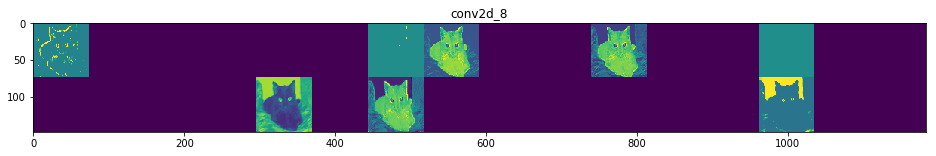

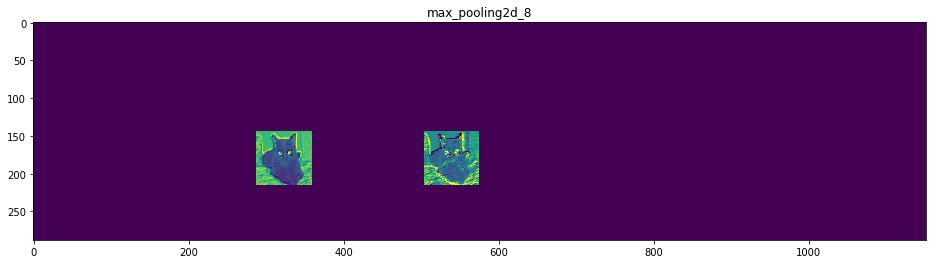

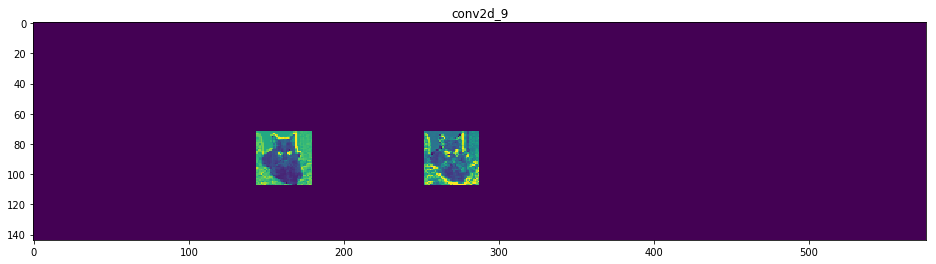

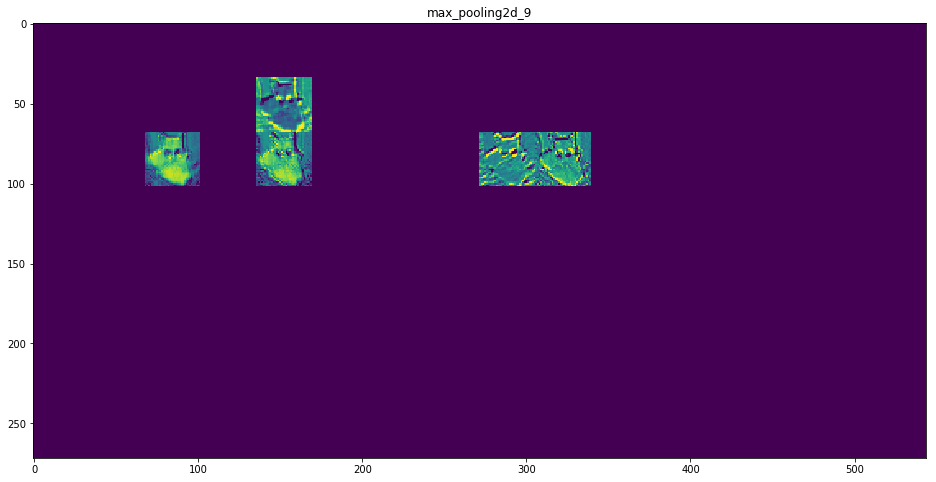

In [9]:
from importlib import reload  # Python 3.4+ only.
import PML

PML.VisualizeActivations(model,X_train[1],5)

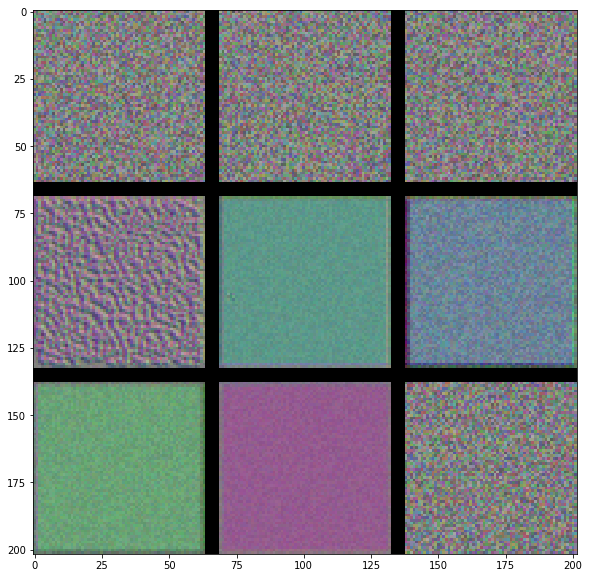

In [17]:
PML.VisualizeLayerActivation(model,'conv2d_4')

## 2. Using pre-trained convnets

The second technique to facilitate the training accuracy is to use an existing trained model. We would only use the trained kernels, and add our own custom Dense layers on top. 

In [12]:
#Loading the model.

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

input_shape=(TARGET_WIDTH,TARGET_HEIGHT,3)
target_model='VGG16'

if(target_model=='VGG16'):
    #from tensorflow.keras.applications import VGG16
    from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
    #First time calling this will download the entire model (~500MB)
    conv_net=VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
elif (target_model=='InceptionV3'):
    #Inception model ~100MB
    from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
    conv_net=InceptionV3(weights='imagenet',include_top=False,input_shape=input_shape)

conv_net.summary()


58892288/58889256 [==============================] - 26s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

In [21]:
from tensorflow.keras import models,layers

model=models.Sequential()
model.add(conv_net)#here we add the entire convnet model
model.add(layers.Flatten())#Flatten the last layer, so we can use our own dense layers
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
conv_net.trainable=True
print("[Before Freezing Conv_Net]: Total number of trainable weights: {0} weights".format(len(model.trainable_weights)))
conv_net.trainable=False
print("[After Freezing Conv_Net]: Total number of trainable weights: {0} weights".format(len(model.trainable_weights)))


[Before Freezing Conv_Net]: Total number of trainable layers: 30 weights
[After Freezing Conv_Net]: Total number of trainable layers: 4 weights


In [ ]:

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit_generator(gen.flow(X_train,Y_train,batch_size=32),
                    validation_data=(X_test,Y_test),
                    steps_per_epoch=50,epochs=20)